# QC using interferon and simulated data

Check calibration of DE/DV/DC using the interferon data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap

<ipython-input-1-779ba7c36955>:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
import memento

In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig3/'
data_path = '/data_volume/parameter_estimation/'

### Computation of residual variance

In [10]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data_volume/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

# pbmc3k_adata = adata[(adata.obs.cell == 'CD14+ Monocytes') & (adata.obs.stim == 'ctrl')]

adata_list = [pbmc3k_adata.copy() for i in range(50)]
pbmc3k_adata = sc.AnnData.concatenate(*adata_list)

sc.pp.filter_cells(pbmc3k_adata, min_genes=200)
pbmc3k_adata.var['mt'] = pbmc3k_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc3k_adata, qc_vars=['mt'], percent_top=None, inplace=True)
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs.pct_counts_mt < 5, :].copy()

pbmc3k_adata.obs['group'] = np.random.choice(['A', 'B'], pbmc3k_adata.shape[0])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
pbmc3k_adata.obs['q'] = 0.07
memento.setup_memento(pbmc3k_adata, q_column='q')
memento.create_groups(pbmc3k_adata, label_columns=['group'])

memento.compute_1d_moments(pbmc3k_adata, min_perc_group=0.8)

In [12]:


memento.ht_1d_moments(
    pbmc3k_adata, 
    formula_like='1 + group',
    cov_column='group', 
    num_boot=1000, 
    verbose=1,
    num_cpus=12)

result_1d = memento.get_1d_ht_result(pbmc3k_adata)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 748 tasks      | elapsed:    4.4s
[Parallel(n_jobs=12)]: Done 2748 tasks      | elapsed:   10.1s
[Parallel(n_jobs=12)]: Done 3219 out of 3242 | elapsed:   11.4s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 3242 out of 3242 | elapsed:   11.6s finished


In [13]:
result_1d.head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,NOC2L,0.031495,0.021921,0.156843,0.223661,0.217647,0.289710
1,HES4,0.034075,0.024794,0.162837,-0.007736,0.039998,0.859141
2,ISG15,-0.000687,0.011384,0.955045,0.015529,0.038646,0.685315
3,TNFRSF4,0.000475,0.028892,0.990010,-0.199972,0.128786,0.135864
4,SDF4,-0.045425,0.015342,0.005538,-0.196646,0.092586,0.029970


<AxesSubplot:>

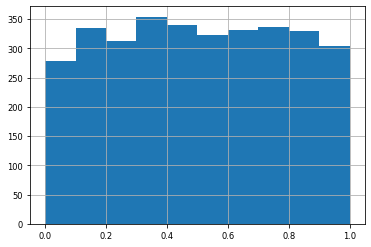

In [14]:
result_1d.dv_pval.hist()

In [15]:
m = np.log(pbmc3k_adata.uns['memento']['1d_moments']['sg^A'][0])
v = np.log(pbmc3k_adata.uns['memento']['1d_moments']['sg^A'][1])
rv = np.log(pbmc3k_adata.uns['memento']['1d_moments']['sg^A'][2])

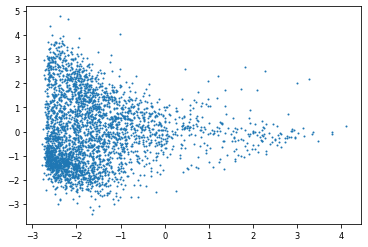

In [16]:
plt.scatter(m,rv, s=1)

In [20]:
x = np.linspace(-2.5, 4, 30)
f = np.poly1d(pbmc3k_adata.uns['memento']['mv_regressor']['sg^B'])
# f = pbmc3k_adata.uns['memento']['mv_regressor']['sg^B']

y = f(x)

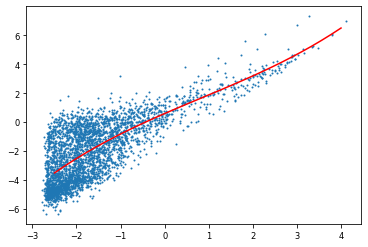

In [21]:
plt.scatter(m,v, s=1)
plt.plot(x,y, color='r')

### 1D/2D calibration on 3K PBMC data with shuffled labels

In [10]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data_volume/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

# pbmc3k_adata = adata[(adata.obs.cell == 'CD14+ Monocytes') & (adata.obs.stim == 'ctrl')]

adata_list = [pbmc3k_adata.copy() for i in range(50)]
pbmc3k_adata = sc.AnnData.concatenate(*adata_list)

sc.pp.filter_cells(pbmc3k_adata, min_genes=200)
pbmc3k_adata.var['mt'] = pbmc3k_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc3k_adata, qc_vars=['mt'], percent_top=None, inplace=True)
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs.pct_counts_mt < 5, :].copy()

pbmc3k_adata.obs['group'] = np.random.choice(['A', 'B'], pbmc3k_adata.shape[0])
pbmc3k_adata.obs['q'] = 0.07
memento.setup_memento(pbmc3k_adata, q_column='q')
memento.create_groups(pbmc3k_adata, label_columns=['group'])

memento.compute_1d_moments(pbmc3k_adata, min_perc_group=0.8)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
memento.ht_1d_moments(
    pbmc3k_adata, 
    formula_like='1 + group',
    cov_column='group', 
    num_boot=1000, 
    verbose=1,
    num_cpus=12)

result_1d = memento.get_1d_ht_result(pbmc3k_adata)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 476 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 1476 tasks      | elapsed:    6.5s
[Parallel(n_jobs=12)]: Done 2876 tasks      | elapsed:   10.5s
[Parallel(n_jobs=12)]: Done 3247 out of 3247 | elapsed:   11.6s finished


In [12]:
random_pairs = [(g1, g2) for g1, g2 in zip(np.random.choice(pbmc3k_adata.var.index, 2500), np.random.choice(pbmc3k_adata.var.index, 2500))]
memento.compute_2d_moments(pbmc3k_adata, random_pairs)

In [13]:
memento.ht_2d_moments(
    pbmc3k_adata, 
    formula_like='1 + group', 
    cov_column='group', 
    num_cpus=6, 
    num_boot=1000)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    1.8s
[Parallel(n_jobs=6)]: Done 314 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 954 tasks      | elapsed:   11.2s
[Parallel(n_jobs=6)]: Done 1850 tasks      | elapsed:   19.7s
[Parallel(n_jobs=6)]: Done 2495 out of 2495 | elapsed:   25.8s finished


In [14]:
pbmc3k_adata.uns.keys()

dict_keys(['memento'])

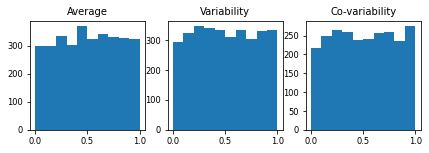

In [15]:
plt.figure(figsize=(7, 2));
plt.subplot(1, 3, 1);
plt.hist(pbmc3k_adata.uns['memento']['1d_ht']['mean_asl'], bins=10); plt.title('Average');
plt.subplot(1, 3, 2);
plt.hist(pbmc3k_adata.uns['memento']['1d_ht']['var_asl'], bins=10); plt.title('Variability');
plt.subplot(1, 3, 3);
plt.hist(pbmc3k_adata.uns['memento']['2d_ht']['corr_asl'], bins=10); plt.title('Co-variability');


### 1D calibration on 3K PBMC data with real labels - memento, MAST, DESeq2


In [20]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

pbmc3k_meta = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/seurat_meta.csv', index_col=0)
pbmc3k_meta.index = pbmc3k_meta.index.map(lambda x: x + '-1')
pbmc3k_adata.obs = pbmc3k_adata.obs.join(pbmc3k_meta, how='left')
# pbmc3k_adata = pbmc3k_adata[~pbmc3k_adata.obs['seurat_clusters'].isnull()]
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs['seurat_clusters'].isin([0, 1])]


In [19]:
pbmc3k_adata.shape

(1180, 32738)

In [20]:
memento.create_groups(pbmc3k_adata, label_columns=['seurat_clusters'], inplace=True, q=0.07)

memento.compute_1d_moments(
    pbmc3k_adata, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.07, trim_percs=0.05,
    min_perc_group=0.8)

Trying to set attribute `.obs` of view, copying.


Using mask...


In [21]:
memento_genes = pbmc3k_adata.var.index.tolist()

In [22]:
memento.ht_1d_moments(
    pbmc3k_adata, 
    formula_like='1 + seurat_clusters',
    cov_column='seurat_clusters', 
    num_boot=10000,
    verbose=1,
    num_cpus=6)

result_1d = memento.get_1d_ht_result(pbmc3k_adata)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   27.5s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   41.7s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   59.4s
[Parallel(n_jobs=6)]: Done 2349 out of 2349 | elapsed:  1.3min finished


In [23]:
result_mast = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_MAST.csv')
result_deseq2 = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_deseq2.csv')
result_wilcox= pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_wilcox.csv')
result_t = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_t.csv')

In [24]:
print('mast', lambda_gc(result_mast['p_val']))
print('deseq2', lambda_gc(result_deseq2['p_val']))
print('t', lambda_gc(result_t['p_val']))
print('memento', lambda_gc(pbmc3k_adata.uns['memento']['1d_ht']['mean_asl']))

NameError: name 'lambda_gc' is not defined

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


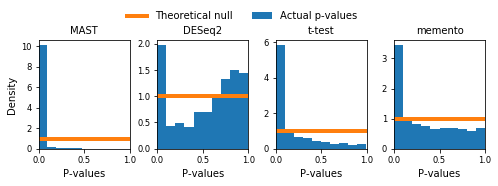

In [25]:
plt.figure(figsize=(8,2));
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 4, 1); plt.title('MAST');
plt.hist(result_mast['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');
plt.ylabel('Density');

plt.subplot(1, 4, 2); plt.title('DESeq2');
plt.hist(result_deseq2['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');

plt.subplot(1, 4, 3); plt.title('t-test');
plt.hist(result_t['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');
plt.legend([ 'Theoretical null','Actual p-values',], bbox_to_anchor=(1, 1.35), ncol=2, frameon=False)

plt.subplot(1, 4, 4); plt.title('memento');
plt.hist(pbmc3k_adata.uns['memento']['1d_ht']['mean_asl'], bins=10, density=True);
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');

plt.savefig(fig_path + 'calibration_comparison.pdf', bbox_inches='tight')



### 1D calibration on 3K PBMC data with shuffled labels - memento, MAST, DESeq2

In [26]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

pbmc3k_meta = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/seurat_meta.csv', index_col=0)
pbmc3k_meta.index = pbmc3k_meta.index.map(lambda x: x + '-1')
pbmc3k_adata.obs = pbmc3k_adata.obs.join(pbmc3k_meta, how='left')
# pbmc3k_adata = pbmc3k_adata[~pbmc3k_adata.obs['seurat_clusters'].isnull()]
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs['seurat_clusters'].isin([0, 1])]

# Shuffle the label
shuffled_pbmc3k_adata = pbmc3k_adata.copy()
shuffled_pbmc3k_adata.obs['seurat_clusters'] = np.random.choice(2, shuffled_pbmc3k_adata.shape[0])

In [27]:
shuffled_pbmc3k_adata.shape

(1180, 32738)

In [28]:
memento.create_groups(shuffled_pbmc3k_adata, label_columns=['seurat_clusters'], inplace=True, q=0.07)

memento.compute_1d_moments(
    shuffled_pbmc3k_adata, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.07, trim_percs=0.05,
    min_perc_group=0.8)

Using mask...


In [29]:
memento_genes = shuffled_pbmc3k_adata.var.index.tolist()

In [30]:
memento.ht_1d_moments(
    shuffled_pbmc3k_adata, 
    formula_like='1 + seurat_clusters',
    cov_column='seurat_clusters', 
    num_boot=10000,
    verbose=1,
    num_cpus=6)

result_1d = memento.get_1d_ht_result(shuffled_pbmc3k_adata)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done 364 tasks      | elapsed:   12.5s
[Parallel(n_jobs=6)]: Done 864 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   53.6s
[Parallel(n_jobs=6)]: Done 2464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2518 out of 2518 | elapsed:  1.4min finished


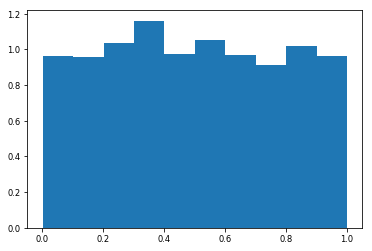

In [31]:
plt.hist(shuffled_pbmc3k_adata.uns['memento']['1d_ht']['mean_asl'], bins=10, density=True);


In [39]:
result_mast = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_MAST_shuffled.csv')
result_deseq2 = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_deseq2_shuffled.csv')
# result_wilcox= pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_wilcox_shuffled.csv')
result_t = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/cd4_t_shuffled.csv')

In [75]:
def lambda_gc(pvals):
    return np.nanmedian(stats.norm.ppf(pvals/2)**2)/stats.chi2.ppf(0.5, df=1)

In [59]:
print('mast', lambda_gc(result_mast['p_val']))
print('deseq2', lambda_gc(result_deseq2['p_val']))
print('t', lambda_gc(result_t['p_val']))
print('memento', lambda_gc(shuffled_pbmc3k_adata.uns['memento']['1d_ht']['mean_asl']))

mast 1.2824011282405157
deseq2 0.2566170480459908
t 1.1175510511646904
memento 0.9955745028623214


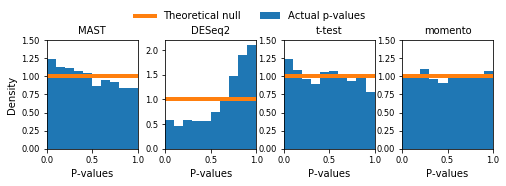

In [62]:
plt.figure(figsize=(8,2));
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 4, 1); plt.title('MAST');
plt.hist(result_mast['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');
plt.ylabel('Density');
plt.ylim(0, 1.5)

plt.subplot(1, 4, 2); plt.title('DESeq2');
plt.hist(result_deseq2['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');#plt.ylim(0, 1.5)


plt.subplot(1, 4, 3); plt.title('t-test');
plt.hist(result_t['p_val'], density=True)
plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');plt.ylim(0, 1.5)

plt.legend([ 'Theoretical null','Actual p-values',], bbox_to_anchor=(1, 1.35), ncol=2, frameon=False)

plt.subplot(1, 4, 4); plt.title('memento');
plt.hist(shuffled_pbmc3k_adata.uns['memento']['1d_ht']['mean_asl'], bins=10, density=True);plt.ylim(0, 1.5)

plt.plot([0, 1], [1,1], lw=4); plt.xlim(0, 1); plt.xlabel('P-values');

plt.savefig(fig_path + 'calibration_comparison_shuffled.pdf', bbox_inches='tight')



In [63]:
print('mast', lambda_gc(result_mast['p_val']))
print('deseq2', lambda_gc(result_deseq2['p_val']))
print('t', lambda_gc(result_t['p_val']))
print('memento', lambda_gc(shuffled_pbmc3k_adata.uns['memento']['1d_ht']['mean_asl']))

mast 1.2824011282405157
deseq2 0.2566170480459908
t 1.1175510511646904
memento 0.9955745028623214


### Investigate volcano plots with shuffled labels in PBMC 3K data

In [10]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data_volume/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

# pbmc3k_adata = adata[(adata.obs.cell == 'CD14+ Monocytes') & (adata.obs.stim == 'ctrl')]

adata_list = [pbmc3k_adata.copy() for i in range(50)]
pbmc3k_adata = sc.AnnData.concatenate(*adata_list)

sc.pp.filter_cells(pbmc3k_adata, min_genes=200)
pbmc3k_adata.var['mt'] = pbmc3k_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc3k_adata, qc_vars=['mt'], percent_top=None, inplace=True)
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs.pct_counts_mt < 5, :].copy()

pbmc3k_adata.obs['group'] = np.random.choice(['A', 'B'], pbmc3k_adata.shape[0])
pbmc3k_adata.obs['q'] = 0.07
memento.setup_memento(pbmc3k_adata, q_column='q')
memento.create_groups(pbmc3k_adata, label_columns=['group'])

memento.compute_1d_moments(pbmc3k_adata, min_perc_group=0.8)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
memento.ht_1d_moments(
    pbmc3k_adata, 
    formula_like='1 + group',
    cov_column='group', 
    num_boot=10000, 
    verbose=1,
    num_cpus=12)

result_1d = memento.get_1d_ht_result(pbmc3k_adata)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  29 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 328 tasks      | elapsed:    5.2s
[Parallel(n_jobs=12)]: Done 828 tasks      | elapsed:   12.1s
[Parallel(n_jobs=12)]: Done 1528 tasks      | elapsed:   22.8s
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:   36.2s
[Parallel(n_jobs=12)]: Done 3224 out of 3247 | elapsed:   48.5s remaining:    0.3s
[Parallel(n_jobs=12)]: Done 3247 out of 3247 | elapsed:   50.1s finished


In [22]:
result_1d['dv_log_pv'] = -np.log(result_1d['dv_pval'])
result_1d['de_log_pv'] = -np.log(result_1d['de_pval'])

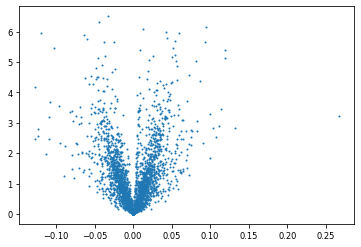

In [23]:
plt.scatter(result_1d['de_coef'], result_1d['de_log_pv'], s=1)

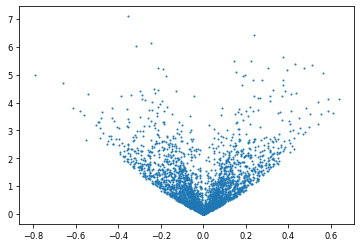

In [21]:
plt.scatter(result_1d['dv_coef'], result_1d['dv_log_pv'], s=1)

### Investigate volcano plots with shuffled labels in IFN PBMC data

In [10]:
fig_path = '~/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data_volume/parameter_estimation/'

In [11]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 0 if x == 'ctrl' else 1)

In [13]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')

In [14]:
memento.create_groups(adata, label_columns=['stim'])

In [15]:
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 

In [16]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + stim',
    cov_column='stim', 
    num_boot=40000, 
    verbose=1,
    num_cpus=12)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   31.2s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 1877 out of 1877 | elapsed:  5.2min finished


In [17]:
result_1d = memento.get_1d_ht_result(adata)
result_1d['dv_log_pv'] = -np.log(result_1d['dv_pval'])
result_1d['de_log_pv'] = -np.log(result_1d['de_pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-1.0, 20.0)

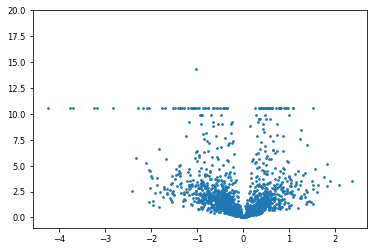

In [20]:
plt.scatter(result_1d['dv_coef'], result_1d['dv_log_pv'], s=3);
plt.ylim(-1, 20)

(-1.0, 12.0)

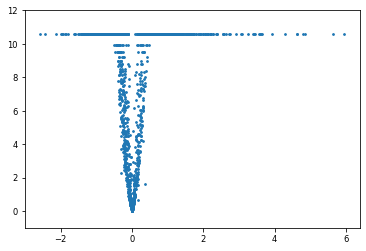

In [21]:
plt.scatter(result_1d['de_coef'], result_1d['de_log_pv'], s=3);
plt.ylim(-1, 12)

In [46]:
x = stats.norm.rvs(size=10000)

In [53]:
tail_data = np.sort(x)[:50]
params = stats.genpareto.fit(tail_data)
_, ks_pval = stats.kstest(tail_data, 'genpareto', args=params)

In [56]:
a = np.linspace(-4, -2.5, 1000)
b = stats.genpareto.pdf(a, *params)

In [54]:
ks_pval

0.17817102072605073

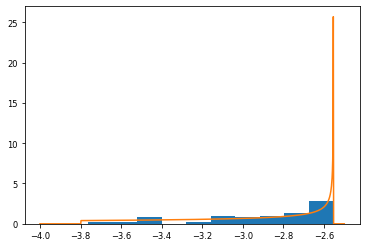

In [58]:
plt.hist(tail_data, density=True)
plt.plot(a,b)

In [ ]:
adata.shape

In [25]:
sc.tl.rank_genes_groups(adata, 'stim', method='wilcoxon', n_genes=1877)
names = [x[0] for x in adata.uns['rank_genes_groups']['names']]
pv = [x[0] for x in adata.uns['rank_genes_groups']['pvals']]
fc = [x[0] for x in adata.uns['rank_genes_groups']['logfoldchanges']]
df = pd.DataFrame(zip(names, pv, fc), columns=['gene', 'pval', 'lfc'])

... storing 'memento_group' as categorical


In [26]:
df['log_pv'] = -np.log(df['pval'])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
df = df.replace([np.inf, -np.inf], 900)

(-20.0, 20.0)

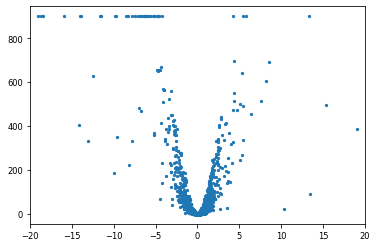

In [28]:
plt.scatter(df['lfc'], df['log_pv'], s=5);
plt.xlim(-20, 20)

### 1D calibration on 3K PBMC data with real labels - SCANPY methods

In [137]:
pbmc3k_adata = sc.read_10x_mtx(
    '/data/parameter_estimation/pbmc3k_calibration/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
sc.pp.filter_cells(pbmc3k_adata, min_genes=200)
sc.pp.filter_genes(pbmc3k_adata, min_cells=3)

# pbmc3k_adata = pbmc3k_adata[~pbmc3k_adata.obs['seurat_clusters'].isnull()]

pbmc3k_adata.var['mt'] = pbmc3k_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(pbmc3k_adata, qc_vars=['mt'], percent_top=None, inplace=True)

pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs.n_genes_by_counts < 2500, :]
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(pbmc3k_adata, target_sum=1e4)
sc.pp.log1p(pbmc3k_adata)
# sc.pp.regress_out(pbmc3k_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(pbmc3k_adata, max_value=10)

pbmc3k_meta = pd.read_csv('/data/parameter_estimation/pbmc3k_calibration/seurat_meta.csv', index_col=0)
pbmc3k_meta.index = pbmc3k_meta.index.map(lambda x: x + '-1')
pbmc3k_adata.obs = pbmc3k_adata.obs.join(pbmc3k_meta, how='left')
pbmc3k_adata = pbmc3k_adata[pbmc3k_adata.obs['seurat_clusters'].isin([0, 1])]
pbmc3k_adata.obs['seurat_clusters'] = pbmc3k_adata.obs['seurat_clusters'].astype('category')

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
Trying to set attribute `.obs` of view, copying.


In [142]:
pbmc3k_adata.shape

(1180, 13714)

In [157]:
sc.tl.rank_genes_groups(pbmc3k_adata, 'seurat_clusters', method='wilcoxon', n_genes=13714)
names = [x[0] for x in pbmc3k_adata.uns['rank_genes_groups']['names']]
pv = [x[0] for x in pbmc3k_adata.uns['rank_genes_groups']['pvals']]
df = pd.DataFrame(zip(names, pv), columns=['gene', 'pval'])
df = df.query('gene in @memento_genes')

(array([3.44095404, 1.09020326, 0.79635941, 0.79210081, 0.77932499,
        0.67711843, 0.58768769, 0.68137704, 0.54936024, 0.60898073]),
 array([3.29973974e-66, 9.99653458e-02, 1.99930692e-01, 2.99896037e-01,
        3.99861383e-01, 4.99826729e-01, 5.99792075e-01, 6.99757421e-01,
        7.99722766e-01, 8.99688112e-01, 9.99653458e-01]),
 <a list of 10 Patch objects>)

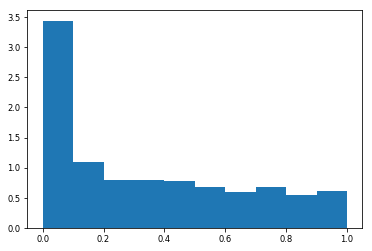

In [158]:
plt.hist(df['pval'], bins=10, density=True)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


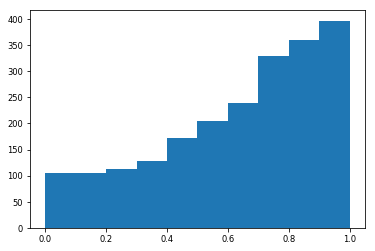

In [158]:
# Summarize DEseq result
deseq_path = '/data/parameter_estimation/pbmc3k_calibration/deseq2/'
deseq_dists = []
for i in range(1,2):
    df = pd.read_csv(deseq_path + '{}.csv'.format(i), index_col=0)
    deseq_dists.append(stats.kstest(df['p_val'].dropna(), 'uniform')[0])
    plt.hist(df['p_val'])

In [159]:
# Summarize MAST result
mast_path = '/data/parameter_estimation/pbmc3k_calibration/mast/'
mast_dists = []
for i in range(1,1):
    df = pd.read_csv(mast_path + '{}.csv'.format(i), index_col=0)
    mast_dists.append(stats.kstest(df['p_val'].dropna(), 'uniform')[0])

In [160]:
np.array(mast_dists).mean()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

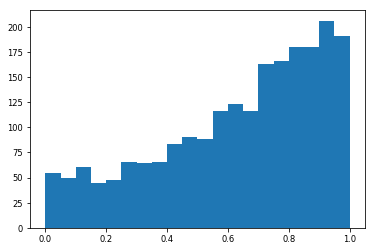

In [161]:
plt.hist(df['p_val'], bins=20);

###

In [175]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')

tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

genes = adata_ct.var.index.tolist()
gene_1 = list(set(tfs) & set(genes))
gene_2 = genes
gene_pairs = list(itertools.product(gene_1, gene_2))

Normalizing with 741 genes
Using mask...


In [179]:
len(gene_1)

43

In [178]:
len(genes)

1596

In [168]:
68628/3600

19.063333333333333

In [167]:
len(gene_pairs)

68628

### Correlation between ISGs

In [233]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()


In [234]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()


In [235]:
x = (adata_ct.X > 0).mean(axis=0).A1

In [236]:
(x > 0.75).sum()

127

In [237]:
a = 0.05

Normalizing with 741 genes
Using mask...
(0.15952003488544897, 7.205063954007968e-13)


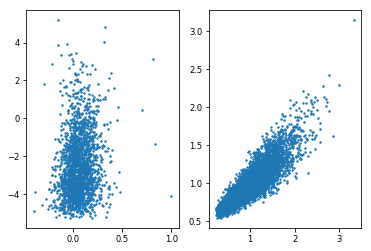

In [238]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    trim_percs=a,
    filter_mean_thresh=0.07, 
    min_perc_group=0.80)
genes = adata_ct.var.index.tolist()
isgf3_genes = list(set(isgf3_genes) & set(genes))

genes = adata_ct.var.index.tolist()
# print(set(tfs) & set(genes))
gene_1 =np.random.choice(genes, 2000, replace=True)
gene_2 = np.random.choice(genes, 2000, replace=True)
gene_pairs = list(zip(gene_1, gene_2))

mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
    adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
print(nancorr(mean_prod, corr))

plt.subplot(1, 2, 1)
plt.scatter(corr, mean_prod, s=2)
plt.subplot(1, 2, 2)
plt.scatter(adata_ct.uns['memento']['all_total_size_factor'], adata_ct.uns['memento']['all_size_factor'], s=2)


In [239]:
0.16391491302445418**2

0.026868098711814378

Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


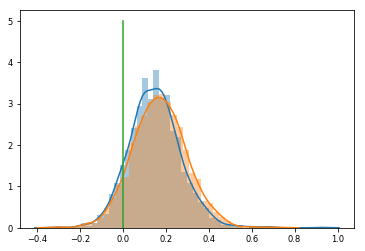

In [44]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    trim_percs=a,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
isgf3_genes = list(set(isgf3_genes) & set(genes))

g = 'ACTB'
gene_1 = [g for i in range(len(genes))]
gene_2 = genes
gene_pairs = list(zip(gene_1, gene_2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

# corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
# plt.scatter(mean_prod, corr, s=2)

# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^ctrl']['corr'])
# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^stim']['corr'])

ctrl, stim = compute_ind_mean(adata_ct)
nandistplot(ctrl)
nandistplot(stim)
plt.plot([0, 0], [0, 5])

In [241]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    trim_percs=a,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
isgf3_genes = list(set(isgf3_genes) & set(genes))

genes = adata_ct.var.index.tolist()
gene_1 = ['NFE2L2']
gene_2 = ['IFIT1', 'ISG15', 'OAS1', 'OASL', 'MX1', 'IFITM1', 'ISG20', 'IFITM3', 'SAT1']
gene_2 = list(set(gene_2) & set(genes))
gene_pairs = list(itertools.product(gene_1, gene_2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

# corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
# plt.scatter(mean_prod, corr, s=2)

# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^ctrl']['corr'])
# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^stim']['corr'])

ctrl, stim = compute_ind_mean(adata_ct)
print(gene_2)
print(ctrl)
print(stim)

Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


['ISG15', 'OASL', 'SAT1', 'OAS1', 'IFITM3', 'ISG20']
[ 0.06236996  0.11912384 -0.00620699  0.0875219   0.02649276  0.05217628]
[ 0.1840114   0.17963484 -0.13797313  0.37650968  0.25553617  0.15137564]


Normalizing with 741 genes
Using mask...


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


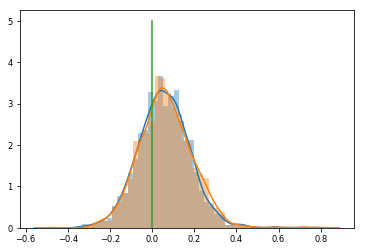

In [36]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,
    trim_percs=a,
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
isgf3_genes = list(set(isgf3_genes) & set(genes))

genes = adata_ct.var.index.tolist()
# print(set(tfs) & set(genes))
gene_1 =np.random.choice(genes, 2000, replace=True)
gene_2 = np.random.choice(genes, 2000, replace=True)
gene_pairs = list(zip(gene_1, gene_2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

# corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
# plt.scatter(mean_prod, corr, s=2)

# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^ctrl']['corr'])
# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^stim']['corr'])

ctrl, stim = compute_ind_mean(adata_ct)
nandistplot(ctrl)
nandistplot(stim)
plt.plot([0, 0], [0, 5])

In [ ]:
result_1d = memento.get_1d_ht_result(adata_ct)

In [ ]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(adata_ct.uns['memento']['1d_ht']['mean_asl'], bins=50);
plt.xlabel('mean pv')
plt.subplot(1, 2, 2)
plt.hist(adata_ct.uns['memento']['1d_ht']['var_asl'], bins=50);
plt.xlabel('var pv')


In [ ]:
result_1d.to_csv('cM_1d_result.csv', index=False)

In [ ]:
result_1d = pd.read_csv('cM_1d_result.csv')

In [ ]:
upreg_genes = result_1d.query('de_fdr < 0.05 & de_coef > 0').sort_values('de_coef', ascending=False).head(20).gene.tolist()

### MISC

In [ ]:
sns.distplot(ctrl_mean_corr)
sns.distplot(stim_mean_corr)
plt.legend(['ctrl', 'stim'])
plt.plot([0, 0], [0, 6])
# plt.xlim(-0.5, 0.5)
# plt.title('Correlation with ' + g)
plt.title('Correlation between random genes')


In [ ]:
stim_mean_corr.shape

In [ ]:
sns.distplot(ctrl_mean_corr, hist=False)
sns.distplot(stim_mean_corr, hist=False)
plt.plot([0, 0], [0, 6])
plt.title('Correlations between highly upregulated genes')

In [ ]:
df['ctrl'] = ctrl_mean_corr
df['stim'] = stim_mean_corr

In [ ]:
df.sort_values('corr_fdr').head(50)

In [ ]:
from sklearn.linear_model import LinearRegression

def _compute_asl(perm_diff):
    """ 
        Use the generalized pareto distribution to model the tail of the permutation distribution. 
    """

    null = perm_diff[1:] - perm_diff[1:].mean()

    stat = perm_diff[0]

    extreme_count = (null < stat).sum()
    extreme_count = min(extreme_count, null.shape[0] - extreme_count)

    print(extreme_count)
    # 	return 2 * ((extreme_count + 1) / (perm_diff.shape[0] + 1))

    if extreme_count > 10: # We do not need to use the GDP approximation. 

        return 2 * ((extreme_count + 1) / (null.shape[0] + 1))

    else: # We use the GDP approximation
        
        try:

            perm_dist = np.sort(null)# if perm_mean < 0 else np.sort(-perm_diff) # For fitting the GDP later on
            perm_dist = perm_dist[np.isfinite(perm_dist)]
            N_exec = 300 # Starting value for number of exceendences

            while N_exec > 50:

                tail_data = perm_dist[-N_exec:] if stat > 0 else perm_dist[:N_exec]
                params = stats.genextreme.fit(tail_data)
                _, ks_pval = stats.kstest(tail_data, 'genextreme', args=params)

                if ks_pval > 0.05: # roughly a genpareto distribution
                    val = stats.genextreme.sf(stat, *params) if stat > 0 else stats.genextreme.cdf(stat, *params)
                    return 2 * (N_exec/perm_diff.shape[0]) * val
                else: # Failed to fit genpareto
                    N_exec -= 30
            return 2 * ((extreme_count + 1) / (perm_diff.shape[0] + 1))

        except: # catch any numerical errors

            # Failed to fit genpareto, return the upper bound
            return 2 * ((extreme_count + 1) / (perm_diff.shape[0] + 1))
        
def _fill_corr(val):
	
	condition = np.isnan(val)
	val[condition] = np.random.choice(val[~condition], condition.sum())
	
	return val

def _ht_2d(
	true_corr, # list of correlations for each group
	cells, # list of Nx2 sparse matrices
	approx_sf,
	design_matrix,
	Nc_list,
	num_boot,
	cov_idx,
	q,
	_estimator_1d,
	_estimator_cov):
		
	good_idxs = np.zeros(design_matrix.shape[0], dtype=bool)
	
	# the bootstrap arrays
	boot_corr = np.zeros((design_matrix.shape[0], num_boot+1))*np.nan

	for group_idx in range(design_matrix.shape[0]):

		# Skip if any of the 2d moments are NaNs
		if np.isnan(true_corr[group_idx]) or (np.abs(true_corr[group_idx]) == 1):
			continue

		# Fill in the true value
		boot_corr[group_idx, 0] = true_corr[group_idx]
		
		# Generate the bootstrap values
		cov, var_1, var_2 = memento.bootstrap._bootstrap_2d(
			data=cells[group_idx],
			size_factor=approx_sf[group_idx],
			num_boot=int(num_boot),
			q=q,
			_estimator_1d=_estimator_1d,
			_estimator_cov=_estimator_cov)
		
# 		var_1[var_1 < 0] = np.mean(var_1[var_1 > 0])
# 		var_2[var_2 < 0] = np.mean(var_2[var_2 > 0])
				
		corr = memento.estimator._corr_from_cov(cov, var_1, var_2, boot=True)
			
		# This replicate is good
		boot_corr[group_idx, 1:] = corr#[:num_boot]
		vals = _fill_corr(boot_corr[group_idx, :])
		
		# Skip if all NaNs
		if np.all(np.isnan(vals)):
			continue
		
		good_idxs[group_idx] = True
		boot_corr[group_idx, :] = vals

	# Skip this gene
	if good_idxs.sum() == 0:
		return np.nan, np.nan
	
	# Skip if each covariate group is not represented
	if np.unique(design_matrix[good_idxs, cov_idx]).shape[0] == 1:
		return np.nan, np.nan
	
	vals = _regress_2d(
			design_matrix=design_matrix[good_idxs, :],
			boot_corr=boot_corr[good_idxs, :],
			Nc_list=Nc_list[good_idxs],
			cov_idx=cov_idx)
	
	return vals


def _regress_2d(design_matrix, boot_corr, Nc_list, cov_idx):
	"""
		Performs hypothesis testing for a single pair of genes for many bootstrap iterations.
	"""
	
	num_boot = boot_corr.shape[1]
	
	boot_corr = boot_corr[:, ~np.any(~np.isfinite(boot_corr), axis=0)]
	
	if boot_corr.shape[1] == 0:
		
		return np.nan, np.nan
	
	corr_coef = LinearRegression(fit_intercept=False, n_jobs=1)\
		.fit(design_matrix, boot_corr, Nc_list).coef_[:, cov_idx]
	
	if boot_corr.shape[1] < num_boot*0.7:
		return corr_coef[0], np.nan

	corr_asl = _compute_asl(corr_coef)
	
	return corr_coef, corr_asl


In [ ]:
from functools import partial

idx_1 = adata_ct.uns['memento']['2d_moments']['gene_idx_1'][0]
idx_2 = adata_ct.uns['memento']['2d_moments']['gene_idx_2'][0]

a = partial(
    _ht_2d,
    true_corr=[adata_ct.uns['memento']['2d_moments'][group]['corr'][0] for group in adata_ct.uns['memento']['groups']],
    cells=[adata_ct.uns['memento']['group_cells'][group][:, [idx_1, idx_2]] for group in adata_ct.uns['memento']['groups']],
    approx_sf=[adata_ct.uns['memento']['approx_size_factor'][group] for group in adata_ct.uns['memento']['groups']],
    design_matrix=adata_ct.uns['memento']['2d_ht']['design_matrix'],
    Nc_list=np.array([adata_ct.uns['memento']['group_cells'][group].shape[0] for group in adata_ct.uns['memento']['groups']]),
    num_boot=100000,
    cov_idx=1,
    q=adata_ct.uns['memento']['q'],
    _estimator_1d=memento.estimator._get_estimator_1d(adata_ct.uns['memento']['estimator_type']),
    _estimator_cov=memento.estimator._get_estimator_cov(adata_ct.uns['memento']['estimator_type']))

In [ ]:
3.433560531085916e-05*1400

In [ ]:
%%time
c, p = a()
print(p)

In [ ]:
%%time
c, p = a()
print(p)

In [ ]:
c[0] = -6

In [ ]:
_compute_asl(c)

In [ ]:
c[0]

In [ ]:
null_dist = c[1:]-c[1:].mean()

In [ ]:
null_dist.min()

In [ ]:
N_exec = 500

In [ ]:
null_dist_tail = np.sort(-null_dist)[-N_exec:]
t = np.sort(-null_dist)[-N_exec-1]
coef = -c[0]

In [ ]:
dist_to_fit = null_dist_tail-t
params = stats.genextreme.fit(dist_to_fit, loc=0)
print(stats.kstest(dist_to_fit, 'genextreme', args=params))

print(stats.genextreme.sf(coef-t, *params))

In [ ]:
sns.distplot(dist_to_fit)
a = stats.genextreme.rvs(*params, size=10000)
sns.distplot(a)
# plt.xlim(0, 0.2)

plt.plot([coef-t, coef-t], [0, 16])